# AI达人创造营作业：模型训练和调参

当数据集准备好后，就需要进行愉快的训练了，在这里 Paddle 为大家提供了很多方便的套件，大大缩短开发者的开发时间，提高了开发效率

* 综合套件：[PaddleHub](https://github.com/PaddlePaddle/PaddleHub)
* 图像分类：[PaddleClas](https://github.com/PaddlePaddle/PaddleClas)
* 目标检测：[PaddleDetection](https://github.com/PaddlePaddle/PaddleDetection)
* 图像分割：[PaddleSeg](https://github.com/PaddlePaddle/PaddleSeg)
* 文字识别：[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR)

更多的套件请访问 [飞桨产品全景](https://www.paddlepaddle.org.cn/overview)

## 作业要求

写出完整的训练代码，并说明使用的套件，使用的优化器，在训练过程调整了那些参数，以及简短的心得

Note ：如果您打算新建项目完成本作业，可以在提交的作业附上链接

**使用的套件：**

PaddleSeg


**使用了什么优化器：**

使用了 PolynomialDecay + Momentum


**调整了那些参数：**

调整了batch szie, num_classes, lambd, loss_types, lr(decay_steps), Momentum, iters


**心得：**

最一开始注意到的是 num_classes, 因为我的这个模型只需要把路面识别出来 所以我一位这里用1就好了. 但是发现效果很不理想.如果想了想 其实 地面是一个类别, 那么所有非地面的就是另外一个类别.所以改成了2. 这和我之前做的 鸟类识别模型遇到的是一个问题.

之后注意到的是 loss_types, 这里BiSeNetV2 需要5个损失函数, 所以一开始选择了 5个都是 CEL(CrossEntropyLoss), 之后想用BCE(BinaryCrossEntropy)但是想到 图片里有大量的天空,人物,建筑物,只有小部分地面,这样就造成了 highly unbalanced label distribution.

再来谈谈CEL, 在CEL里面 损失是通过计算平均每一个像素的损失值来获得的,而且每个像素的损失值都是分散计算的.这样做在计算每个像素的损失值的时候就完全没有考虑到它周围相邻像素值的情况.这就导致了CEL只注重微观视野,而忽略了整体,所以对于图像级别的预测效果将不会太好.([reference: Understanding Dice Loss for Crisp Boundary Detection](https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b))

混合进了2个DiceLoss(DL). 相较于CEL的"近视", DL在计算损失值的时候可以做到"具体"与"宏观"兼备,因为大幅度底稿准确率. 具体原理也请看上面的reference.

lr的decay_steps我选择了和train()里面的iters是一样的.(虽然用了3000,那是因为之前iters是用3000,后来加到6000忘记改变这个decay_steps啦....)

由于怕算法陷入local maxima而跑不出来,导致找不到global maxima 所以用了 momentum.

batch size(BS)是我这次学到最大的知识点之一. 之前对BS的了解就是它指定了每一批训练时用到的图片的数量.感觉这个和训练精度没有关系,只和训练速度快慢有关系. 但是听完解释之后 才知道如果BS选的太大了 那么即使每次做修正的时候对错误的修正也不会太强, 但是选小了的话,那么会有很大影响 不一定是好事. 所以这个BS的选择真的是要 好好炼丹...(这里要特别感谢 助教:红白黑, 的细心解释.点赞!!!)

In [ ]:
! pip install paddleseg

In [ ]:
!git clone https://gitee.com/paddlepaddle/PaddleSeg.git

In [3]:
%cd work/PaddleSeg
%pwd

/home/aistudio/work/PaddleSeg


'/home/aistudio/work/PaddleSeg'

In [ ]:
# 先来看看管用不
!python predict.py \
       --config configs/quick_start/bisenet_optic_disc_512x512_1k.yml \
       --model_path https://bj.bcebos.com/paddleseg/dygraph/optic_disc/bisenet_optic_disc_512x512_1k/model.pdparams\
       --image_path docs/images/optic_test_image.jpg \
       --save_dir output/result

2021-08-14 07:41:35 [INFO]	
---------------Config Information---------------
batch_size: 4
iters: 1000
loss:
  coef:
  - 1
  - 1
  - 1
  - 1
  - 1
  types:
  - type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.01
  power: 0.9
  type: PolynomialDecay
model:
  pretrained: null
  type: BiSeNetV2
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 4.0e-05
train_dataset:
  dataset_root: data/optic_disc_seg
  mode: train
  transforms:
  - target_size:
    - 512
    - 512
    type: Resize
  - type: RandomHorizontalFlip
  - type: Normalize
  type: OpticDiscSeg
val_dataset:
  dataset_root: data/optic_disc_seg
  mode: val
  transforms:
  - target_size:
    - 512
    - 512
    type: Resize
  - type: Normalize
  type: OpticDiscSeg
------------------------------------------------
W0814 07:41:35.771314   152 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0814 07:41:35.771361   152 device_context.cc

备注: 本作业使用到的数据集是收集与澳大利亚墨尔本地区的 超市,公元,商场,居民区小路.

在这里可以找到这个[数据集](https://aistudio.baidu.com/aistudio/datasetdetail/104246)

这里要表扬一个帮了大忙 节省了至少N倍时间的标注工具, 不是LabelMe,是 咱们Paddle自己出的 EISeg!

真是太好用啦~! 具体怎样好用, 你要先被LabelMe折磨过,再来用EISeg标注,你就知道它有多香了!

我还出现了一个状况....就是用EISeg标准东西会上瘾....命名时间都不够了,但是我还想标注更多图,也不知道为什么会这么上瘾....哈哈哈

In [1]:
# read in the image-annotation pairs
with open('/home/aistudio/work/PaddleSeg/data/road_seg/list.txt', 'r') as data_list:
    lines = data_list.readlines()

# time to split the dataset into train, test subsets
import numpy as np
from sklearn.model_selection import train_test_split

dataset = np.array([(line.split(' ')[0], str.strip(line.split(' ')[1])) for line in lines])
x = dataset[:,0]
y = dataset[:,1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=True, random_state=1)

len(x_train), x_train[3], len(y_train), y_train[3], len(x_test), x_test[3], len(y_test), y_test[3], len(lines)

(325,
 './JPEGImages/cp_0015.jpeg',
 325,
 './Annotations/cp_0015.png',
 82,
 './JPEGImages/boxhill_093.jpeg',
 82,
 './Annotations/boxhill_093.png',
 407)

In [4]:
# construct train.txt and test.txt
def generate_txt(x, y, fn):
    lines = []
    for img, annotation in zip(x,y):
        line = '{} {}\n'.format(img, annotation)
        lines.append(line)

    with open(fn, 'w') as txt_file:
        txt_file.writelines(lines)

train_path = './data/road_seg/train.txt'
test_path = './data/road_seg/test.txt'
generate_txt(x_train, y_train, train_path)
generate_txt(x_test, y_test, test_path)

In [5]:
# Define the data transformer for data augmentation

import paddleseg.transforms as T

# More options to try
# T.ResizeStepScaling(min_scale_factor=0.75, max_scale_factor=2.0, scale_step_size=0.25),
# T.RandomDistort(brightness_range=0.4, contrast_range=0.4, saturation_range=0.4),

train_transforms = [
    T.RandomPaddingCrop(crop_size=(384,384)),
    T.RandomHorizontalFlip(prob=0.3),
    T.Resize(target_size=(416,416)),
    T.Normalize()
]

val_transforms = [
    T.Resize(target_size=(416,416)),
    T.Normalize()
]

from paddleseg.datasets import Dataset

dataset_dir = './data/road_seg'

train_dataset = Dataset(
    dataset_root = dataset_dir,
    train_path = train_path,
    num_classes = 2,
    transforms = train_transforms,
    edge = True,
    separator=' ',
    ignore_index=255,
    mode = 'train'
)

val_dataset = Dataset(
    dataset_root = dataset_dir,
    val_path = test_path,
    num_classes = 2,
    transforms = val_transforms,
    separator=' ',
    ignore_index=255,
    mode = 'val'
)

In [6]:
print('图片：')
print(type(train_dataset[0][0]))
print(train_dataset[0][0])
print('标签：')
print(type(train_dataset[0][1]))
print(train_dataset[0][1])

图片：
<class 'numpy.ndarray'>
[[[0.3176471  0.3176471  0.3176471  ... 0.254902   0.254902   0.254902  ]
  [0.3176471  0.3176471  0.3176471  ... 0.254902   0.254902   0.254902  ]
  [0.32398188 0.32398188 0.3188653  ... 0.254902   0.254902   0.254902  ]
  ...
  [0.4901961  0.4901961  0.4901961  ... 0.45882356 0.45882356 0.45882356]
  [0.4901961  0.4901961  0.4901961  ... 0.45882356 0.45882356 0.45882356]
  [0.4901961  0.4901961  0.4901961  ... 0.45882356 0.45882356 0.45882356]]

 [[0.30980396 0.30980396 0.30980396 ... 0.27058828 0.27058828 0.27058828]
  [0.30980396 0.30980396 0.30980396 ... 0.27058828 0.27058828 0.27058828]
  [0.31613874 0.31613874 0.31102216 ... 0.27058828 0.27058828 0.27058828]
  ...
  [0.4666667  0.4666667  0.4666667  ... 0.4666667  0.4666667  0.4666667 ]
  [0.4666667  0.4666667  0.4666667  ... 0.4666667  0.4666667  0.4666667 ]
  [0.4666667  0.4666667  0.4666667  ... 0.4666667  0.4666667  0.4666667 ]]

 [[0.27058828 0.27058828 0.27058828 ... 0.18431377 0.18431377 0.1843

(416, 416, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


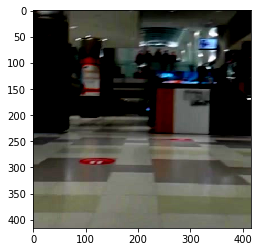

In [14]:
from matplotlib import pyplot as plt

view = train_dataset[0][0].transpose(1,2,0)

plt.figure()
plt.imshow(view)
plt.show()

In [15]:
import paddle
from paddleseg.models import BiSeNetV2
from paddleseg.models.losses import CrossEntropyLoss, DiceLoss
from paddleseg.core import train, val, infer

model = BiSeNetV2(
    num_classes=2,
    lambd=0.25
)

loss_types = [
    CrossEntropyLoss(),  # 像素级优化
    CrossEntropyLoss(),
    CrossEntropyLoss(),
    DiceLoss(),  # 整体/局部的优化
    DiceLoss()
]
loss_coefs = [1.0] * 5
loss_dict = {'types': loss_types, 'coef': loss_coefs}

lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=0.01, decay_steps=3000, end_lr=0.0001)
opt_choice = paddle.optimizer.Momentum(learning_rate=lr, momentum=0.9, parameters=model.parameters())

In [19]:
model.named_parameters

<bound method Layer.named_parameters of BiSeNetV2(
  (db): DetailBranch(
    (convs): Sequential(
      (0): ConvBNReLU(
        (_conv): Conv2D(3, 64, kernel_size=[3, 3], stride=[2, 2], padding=same, data_format=NCHW)
        (_batch_norm): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      )
      (1): ConvBNReLU(
        (_conv): Conv2D(64, 64, kernel_size=[3, 3], padding=same, data_format=NCHW)
        (_batch_norm): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      )
      (2): ConvBNReLU(
        (_conv): Conv2D(64, 64, kernel_size=[3, 3], stride=[2, 2], padding=same, data_format=NCHW)
        (_batch_norm): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      )
      (3): ConvBNReLU(
        (_conv): Conv2D(64, 64, kernel_size=[3, 3], padding=same, data_format=NCHW)
        (_batch_norm): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      )
      (4): ConvBNReLU(
        (_conv): Conv2D(64, 64, kernel_size=[3, 3], padding=same, 

In [19]:
train(
    model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=opt_choice,
    save_dir='output',
    iters=6000,
    batch_size=8,
    save_interval=100,
    log_iters=20,
    num_workers=0,
    use_vdl=False,
    losses=loss_dict,
    keep_checkpoint_max=5
)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.bool, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


2021-08-14 08:05:32 [INFO]	[TRAIN] epoch: 1, iter: 20/6000, loss: 2.5284, lr: 0.009937, batch_cost: 0.5262, reader_cost: 0.41899, ips: 15.2046 samples/sec | ETA 00:52:26
2021-08-14 08:05:42 [INFO]	[TRAIN] epoch: 1, iter: 40/6000, loss: 1.7728, lr: 0.009871, batch_cost: 0.5115, reader_cost: 0.40676, ips: 15.6414 samples/sec | ETA 00:50:48
2021-08-14 08:05:52 [INFO]	[TRAIN] epoch: 2, iter: 60/6000, loss: 1.4548, lr: 0.009805, batch_cost: 0.5129, reader_cost: 0.40864, ips: 15.5968 samples/sec | ETA 00:50:46
2021-08-14 08:06:03 [INFO]	[TRAIN] epoch: 2, iter: 80/6000, loss: 1.4660, lr: 0.009739, batch_cost: 0.5099, reader_cost: 0.40349, ips: 15.6885 samples/sec | ETA 00:50:18
2021-08-14 08:06:13 [INFO]	[TRAIN] epoch: 3, iter: 100/6000, loss: 1.3055, lr: 0.009673, batch_cost: 0.5152, reader_cost: 0.41023, ips: 15.5283 samples/sec | ETA 00:50:39
2021-08-14 08:06:13 [INFO]	Start evaluating (total_samples: 82, total_iters: 82)...


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int32, but right dtype is paddle.bool, the right dtype will convert to paddle.int32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.bool, the right dtype will convert to paddle.int64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0321 - reader cost: 3.6484e-


2021-08-14 08:06:16 [INFO]	[EVAL] #Images: 82 mIoU: 0.8397 Acc: 0.9263 Kappa: 0.8238 
2021-08-14 08:06:16 [INFO]	[EVAL] Class IoU: 
[0.9005 0.7789]
2021-08-14 08:06:16 [INFO]	[EVAL] Class Acc: 
[0.9187 0.9466]
2021-08-14 08:06:16 [INFO]	[EVAL] The model with the best validation mIoU (0.8397) was saved at iter 100.
2021-08-14 08:06:23 [INFO]	[TRAIN] epoch: 3, iter: 120/6000, loss: 1.3588, lr: 0.009607, batch_cost: 0.3943, reader_cost: 0.28993, ips: 20.2875 samples/sec | ETA 00:38:38
2021-08-14 08:06:34 [INFO]	[TRAIN] epoch: 4, iter: 140/6000, loss: 1.3154, lr: 0.009541, batch_cost: 0.5160, reader_cost: 0.40791, ips: 15.5053 samples/sec | ETA 00:50:23
2021-08-14 08:06:44 [INFO]	[TRAIN] epoch: 4, iter: 160/6000, loss: 1.1728, lr: 0.009475, batch_cost: 0.5111, reader_cost: 0.40595, ips: 15.6530 samples/sec | ETA 00:49:44
2021-08-14 08:06:54 [INFO]	[TRAIN] epoch: 5, iter: 180/6000, loss: 1.2145, lr: 0.009409, batch_cost: 0.5224, reader_cost: 0.41651, ips: 15.3146 samples/sec | ETA 00:50:40


82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0289 - reader cost: 3.1436e-


2021-08-14 08:07:07 [INFO]	[EVAL] #Images: 82 mIoU: 0.8848 Acc: 0.9473 Kappa: 0.8768 
2021-08-14 08:07:07 [INFO]	[EVAL] Class IoU: 
[0.9264 0.8432]
2021-08-14 08:07:07 [INFO]	[EVAL] Class Acc: 
[0.9498 0.9414]
2021-08-14 08:07:07 [INFO]	[EVAL] The model with the best validation mIoU (0.8848) was saved at iter 200.
2021-08-14 08:07:18 [INFO]	[TRAIN] epoch: 6, iter: 220/6000, loss: 1.1039, lr: 0.009277, batch_cost: 0.5154, reader_cost: 0.41137, ips: 15.5227 samples/sec | ETA 00:49:38
2021-08-14 08:07:28 [INFO]	[TRAIN] epoch: 6, iter: 240/6000, loss: 1.0662, lr: 0.009211, batch_cost: 0.5132, reader_cost: 0.40932, ips: 15.5883 samples/sec | ETA 00:49:16
2021-08-14 08:07:38 [INFO]	[TRAIN] epoch: 7, iter: 260/6000, loss: 1.0660, lr: 0.009145, batch_cost: 0.5191, reader_cost: 0.41484, ips: 15.4099 samples/sec | ETA 00:49:39
2021-08-14 08:07:49 [INFO]	[TRAIN] epoch: 7, iter: 280/6000, loss: 1.1709, lr: 0.009079, batch_cost: 0.5130, reader_cost: 0.40894, ips: 15.5959 samples/sec | ETA 00:48:54


82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0323 - reader cost: 3.6125e-


2021-08-14 08:08:02 [INFO]	[EVAL] #Images: 82 mIoU: 0.9082 Acc: 0.9585 Kappa: 0.9032 
2021-08-14 08:08:02 [INFO]	[EVAL] Class IoU: 
[0.9415 0.875 ]
2021-08-14 08:08:02 [INFO]	[EVAL] Class Acc: 
[0.9596 0.956 ]
2021-08-14 08:08:02 [INFO]	[EVAL] The model with the best validation mIoU (0.9082) was saved at iter 300.
2021-08-14 08:08:10 [INFO]	[TRAIN] epoch: 8, iter: 320/6000, loss: 1.0529, lr: 0.008947, batch_cost: 0.3943, reader_cost: 0.28978, ips: 20.2891 samples/sec | ETA 00:37:19
2021-08-14 08:08:20 [INFO]	[TRAIN] epoch: 9, iter: 340/6000, loss: 1.0843, lr: 0.008881, batch_cost: 0.5158, reader_cost: 0.41026, ips: 15.5096 samples/sec | ETA 00:48:39
2021-08-14 08:08:30 [INFO]	[TRAIN] epoch: 9, iter: 360/6000, loss: 1.0599, lr: 0.008815, batch_cost: 0.5060, reader_cost: 0.40080, ips: 15.8116 samples/sec | ETA 00:47:33
2021-08-14 08:08:40 [INFO]	[TRAIN] epoch: 10, iter: 380/6000, loss: 1.0121, lr: 0.008749, batch_cost: 0.5131, reader_cost: 0.40796, ips: 15.5918 samples/sec | ETA 00:48:03

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0298 - reader cost: 2.7665e-


2021-08-14 08:08:53 [INFO]	[EVAL] #Images: 82 mIoU: 0.8767 Acc: 0.9435 Kappa: 0.8675 
2021-08-14 08:08:53 [INFO]	[EVAL] Class IoU: 
[0.9215 0.8319]
2021-08-14 08:08:53 [INFO]	[EVAL] Class Acc: 
[0.9447 0.9405]
2021-08-14 08:08:53 [INFO]	[EVAL] The model with the best validation mIoU (0.9082) was saved at iter 300.
2021-08-14 08:09:03 [INFO]	[TRAIN] epoch: 11, iter: 420/6000, loss: 1.0716, lr: 0.008617, batch_cost: 0.5145, reader_cost: 0.40901, ips: 15.5492 samples/sec | ETA 00:47:50
2021-08-14 08:09:13 [INFO]	[TRAIN] epoch: 11, iter: 440/6000, loss: 1.0126, lr: 0.008551, batch_cost: 0.5056, reader_cost: 0.40089, ips: 15.8214 samples/sec | ETA 00:46:51
2021-08-14 08:09:24 [INFO]	[TRAIN] epoch: 12, iter: 460/6000, loss: 0.9619, lr: 0.008485, batch_cost: 0.5122, reader_cost: 0.40717, ips: 15.6187 samples/sec | ETA 00:47:17
2021-08-14 08:09:34 [INFO]	[TRAIN] epoch: 12, iter: 480/6000, loss: 1.0209, lr: 0.008419, batch_cost: 0.5073, reader_cost: 0.40143, ips: 15.7697 samples/sec | ETA 00:46

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0324 - reader cost: 3.8057e-


2021-08-14 08:09:47 [INFO]	[EVAL] #Images: 82 mIoU: 0.8945 Acc: 0.9521 Kappa: 0.8878 
2021-08-14 08:09:47 [INFO]	[EVAL] Class IoU: 
[0.933  0.8561]
2021-08-14 08:09:47 [INFO]	[EVAL] Class Acc: 
[0.9523 0.9517]
2021-08-14 08:09:47 [INFO]	[EVAL] The model with the best validation mIoU (0.9082) was saved at iter 300.
2021-08-14 08:09:55 [INFO]	[TRAIN] epoch: 13, iter: 520/6000, loss: 0.9962, lr: 0.008287, batch_cost: 0.4037, reader_cost: 0.29893, ips: 19.8191 samples/sec | ETA 00:36:52
2021-08-14 08:10:05 [INFO]	[TRAIN] epoch: 14, iter: 540/6000, loss: 0.9751, lr: 0.008221, batch_cost: 0.5158, reader_cost: 0.41070, ips: 15.5089 samples/sec | ETA 00:46:56
2021-08-14 08:10:15 [INFO]	[TRAIN] epoch: 14, iter: 560/6000, loss: 1.0172, lr: 0.008155, batch_cost: 0.5046, reader_cost: 0.40021, ips: 15.8544 samples/sec | ETA 00:45:44
2021-08-14 08:10:26 [INFO]	[TRAIN] epoch: 15, iter: 580/6000, loss: 0.9377, lr: 0.008089, batch_cost: 0.5079, reader_cost: 0.40427, ips: 15.7503 samples/sec | ETA 00:45

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0294 - reader cost: 2.8548e-


2021-08-14 08:10:38 [INFO]	[EVAL] #Images: 82 mIoU: 0.8924 Acc: 0.9513 Kappa: 0.8854 
2021-08-14 08:10:38 [INFO]	[EVAL] Class IoU: 
[0.9322 0.8526]
2021-08-14 08:10:38 [INFO]	[EVAL] Class Acc: 
[0.9477 0.9599]
2021-08-14 08:10:38 [INFO]	[EVAL] The model with the best validation mIoU (0.9082) was saved at iter 300.
2021-08-14 08:10:48 [INFO]	[TRAIN] epoch: 16, iter: 620/6000, loss: 0.9897, lr: 0.007957, batch_cost: 0.5056, reader_cost: 0.40063, ips: 15.8233 samples/sec | ETA 00:45:20
2021-08-14 08:10:58 [INFO]	[TRAIN] epoch: 16, iter: 640/6000, loss: 0.9139, lr: 0.007891, batch_cost: 0.5020, reader_cost: 0.39793, ips: 15.9348 samples/sec | ETA 00:44:50
2021-08-14 08:11:08 [INFO]	[TRAIN] epoch: 17, iter: 660/6000, loss: 0.9329, lr: 0.007825, batch_cost: 0.5052, reader_cost: 0.40141, ips: 15.8367 samples/sec | ETA 00:44:57
2021-08-14 08:11:18 [INFO]	[TRAIN] epoch: 17, iter: 680/6000, loss: 0.9150, lr: 0.007759, batch_cost: 0.5010, reader_cost: 0.39733, ips: 15.9677 samples/sec | ETA 00:44

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0313 - reader cost: 3.0721e-


2021-08-14 08:11:31 [INFO]	[EVAL] #Images: 82 mIoU: 0.9205 Acc: 0.9639 Kappa: 0.9167 
2021-08-14 08:11:31 [INFO]	[EVAL] Class IoU: 
[0.9484 0.8925]
2021-08-14 08:11:31 [INFO]	[EVAL] Class Acc: 
[0.9729 0.9445]
2021-08-14 08:11:31 [INFO]	[EVAL] The model with the best validation mIoU (0.9205) was saved at iter 700.
2021-08-14 08:11:39 [INFO]	[TRAIN] epoch: 18, iter: 720/6000, loss: 0.8507, lr: 0.007627, batch_cost: 0.3918, reader_cost: 0.28759, ips: 20.4162 samples/sec | ETA 00:34:28
2021-08-14 08:11:49 [INFO]	[TRAIN] epoch: 19, iter: 740/6000, loss: 0.9481, lr: 0.007561, batch_cost: 0.5052, reader_cost: 0.40149, ips: 15.8353 samples/sec | ETA 00:44:17
2021-08-14 08:11:59 [INFO]	[TRAIN] epoch: 19, iter: 760/6000, loss: 0.9217, lr: 0.007495, batch_cost: 0.5003, reader_cost: 0.39641, ips: 15.9888 samples/sec | ETA 00:43:41
2021-08-14 08:12:09 [INFO]	[TRAIN] epoch: 20, iter: 780/6000, loss: 0.8621, lr: 0.007429, batch_cost: 0.5143, reader_cost: 0.40889, ips: 15.5542 samples/sec | ETA 00:44

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0285 - reader cost: 2.7740e-


2021-08-14 08:12:22 [INFO]	[EVAL] #Images: 82 mIoU: 0.9214 Acc: 0.9644 Kappa: 0.9178 
2021-08-14 08:12:22 [INFO]	[EVAL] Class IoU: 
[0.9492 0.8937]
2021-08-14 08:12:22 [INFO]	[EVAL] Class Acc: 
[0.9722 0.9476]
2021-08-14 08:12:22 [INFO]	[EVAL] The model with the best validation mIoU (0.9214) was saved at iter 800.
2021-08-14 08:12:32 [INFO]	[TRAIN] epoch: 21, iter: 820/6000, loss: 0.9172, lr: 0.007297, batch_cost: 0.5058, reader_cost: 0.40130, ips: 15.8153 samples/sec | ETA 00:43:40
2021-08-14 08:12:42 [INFO]	[TRAIN] epoch: 21, iter: 840/6000, loss: 0.8950, lr: 0.007231, batch_cost: 0.4991, reader_cost: 0.39551, ips: 16.0296 samples/sec | ETA 00:42:55
2021-08-14 08:12:52 [INFO]	[TRAIN] epoch: 22, iter: 860/6000, loss: 0.8393, lr: 0.007165, batch_cost: 0.5156, reader_cost: 0.41042, ips: 15.5170 samples/sec | ETA 00:44:09
2021-08-14 08:13:02 [INFO]	[TRAIN] epoch: 22, iter: 880/6000, loss: 0.9229, lr: 0.007099, batch_cost: 0.5034, reader_cost: 0.39962, ips: 15.8905 samples/sec | ETA 00:42

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0310 - reader cost: 3.1418e-


2021-08-14 08:13:15 [INFO]	[EVAL] #Images: 82 mIoU: 0.9172 Acc: 0.9625 Kappa: 0.9132 
2021-08-14 08:13:15 [INFO]	[EVAL] Class IoU: 
[0.9468 0.8877]
2021-08-14 08:13:15 [INFO]	[EVAL] Class Acc: 
[0.9674 0.9517]
2021-08-14 08:13:15 [INFO]	[EVAL] The model with the best validation mIoU (0.9214) was saved at iter 800.
2021-08-14 08:13:23 [INFO]	[TRAIN] epoch: 23, iter: 920/6000, loss: 0.8881, lr: 0.006967, batch_cost: 0.3883, reader_cost: 0.28418, ips: 20.6010 samples/sec | ETA 00:32:52
2021-08-14 08:13:33 [INFO]	[TRAIN] epoch: 24, iter: 940/6000, loss: 0.8789, lr: 0.006901, batch_cost: 0.5051, reader_cost: 0.40116, ips: 15.8379 samples/sec | ETA 00:42:35
2021-08-14 08:13:43 [INFO]	[TRAIN] epoch: 24, iter: 960/6000, loss: 0.9055, lr: 0.006835, batch_cost: 0.4987, reader_cost: 0.39503, ips: 16.0402 samples/sec | ETA 00:41:53
2021-08-14 08:13:53 [INFO]	[TRAIN] epoch: 25, iter: 980/6000, loss: 0.9346, lr: 0.006769, batch_cost: 0.5063, reader_cost: 0.40253, ips: 15.8015 samples/sec | ETA 00:42

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0291 - reader cost: 2.8484e-


2021-08-14 08:14:06 [INFO]	[EVAL] #Images: 82 mIoU: 0.9214 Acc: 0.9643 Kappa: 0.9178 
2021-08-14 08:14:06 [INFO]	[EVAL] Class IoU: 
[0.9491 0.8937]
2021-08-14 08:14:06 [INFO]	[EVAL] Class Acc: 
[0.9728 0.9462]
2021-08-14 08:14:06 [INFO]	[EVAL] The model with the best validation mIoU (0.9214) was saved at iter 800.
2021-08-14 08:14:16 [INFO]	[TRAIN] epoch: 26, iter: 1020/6000, loss: 0.8558, lr: 0.006637, batch_cost: 0.5088, reader_cost: 0.40414, ips: 15.7225 samples/sec | ETA 00:42:13
2021-08-14 08:14:26 [INFO]	[TRAIN] epoch: 26, iter: 1040/6000, loss: 0.8083, lr: 0.006571, batch_cost: 0.5014, reader_cost: 0.39732, ips: 15.9558 samples/sec | ETA 00:41:26
2021-08-14 08:14:36 [INFO]	[TRAIN] epoch: 27, iter: 1060/6000, loss: 0.7934, lr: 0.006505, batch_cost: 0.5063, reader_cost: 0.40186, ips: 15.8008 samples/sec | ETA 00:41:41
2021-08-14 08:14:46 [INFO]	[TRAIN] epoch: 27, iter: 1080/6000, loss: 0.8432, lr: 0.006439, batch_cost: 0.5022, reader_cost: 0.39831, ips: 15.9287 samples/sec | ETA 0

82/82 [==============================] - 3s 38ms/step - batch_cost: 0.0371 - reader cost: 3.8173e-0


2021-08-14 08:15:00 [INFO]	[EVAL] #Images: 82 mIoU: 0.9234 Acc: 0.9655 Kappa: 0.9199 
2021-08-14 08:15:00 [INFO]	[EVAL] Class IoU: 
[0.9509 0.896 ]
2021-08-14 08:15:00 [INFO]	[EVAL] Class Acc: 
[0.9693 0.957 ]
2021-08-14 08:15:00 [INFO]	[EVAL] The model with the best validation mIoU (0.9234) was saved at iter 1100.
2021-08-14 08:15:07 [INFO]	[TRAIN] epoch: 28, iter: 1120/6000, loss: 0.8284, lr: 0.006307, batch_cost: 0.3918, reader_cost: 0.28662, ips: 20.4186 samples/sec | ETA 00:31:51
2021-08-14 08:15:17 [INFO]	[TRAIN] epoch: 29, iter: 1140/6000, loss: 0.8329, lr: 0.006241, batch_cost: 0.5026, reader_cost: 0.39803, ips: 15.9165 samples/sec | ETA 00:40:42
2021-08-14 08:15:27 [INFO]	[TRAIN] epoch: 29, iter: 1160/6000, loss: 0.8201, lr: 0.006175, batch_cost: 0.4988, reader_cost: 0.39420, ips: 16.0378 samples/sec | ETA 00:40:14
2021-08-14 08:15:38 [INFO]	[TRAIN] epoch: 30, iter: 1180/6000, loss: 0.8391, lr: 0.006109, batch_cost: 0.5041, reader_cost: 0.39917, ips: 15.8698 samples/sec | ETA 

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0289 - reader cost: 2.7618e-


2021-08-14 08:15:50 [INFO]	[EVAL] #Images: 82 mIoU: 0.9263 Acc: 0.9667 Kappa: 0.9231 
2021-08-14 08:15:50 [INFO]	[EVAL] Class IoU: 
[0.9525 0.9002]
2021-08-14 08:15:50 [INFO]	[EVAL] Class Acc: 
[0.9732 0.9527]
2021-08-14 08:15:50 [INFO]	[EVAL] The model with the best validation mIoU (0.9263) was saved at iter 1200.
2021-08-14 08:16:00 [INFO]	[TRAIN] epoch: 31, iter: 1220/6000, loss: 0.8474, lr: 0.005977, batch_cost: 0.5038, reader_cost: 0.39921, ips: 15.8807 samples/sec | ETA 00:40:07
2021-08-14 08:16:10 [INFO]	[TRAIN] epoch: 31, iter: 1240/6000, loss: 0.8208, lr: 0.005911, batch_cost: 0.4985, reader_cost: 0.39416, ips: 16.0485 samples/sec | ETA 00:39:32
2021-08-14 08:16:20 [INFO]	[TRAIN] epoch: 32, iter: 1260/6000, loss: 0.9307, lr: 0.005845, batch_cost: 0.5009, reader_cost: 0.39698, ips: 15.9706 samples/sec | ETA 00:39:34
2021-08-14 08:16:30 [INFO]	[TRAIN] epoch: 32, iter: 1280/6000, loss: 0.7716, lr: 0.005779, batch_cost: 0.4961, reader_cost: 0.39168, ips: 16.1263 samples/sec | ETA 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0327 - reader cost: 3.3710e-


2021-08-14 08:16:43 [INFO]	[EVAL] #Images: 82 mIoU: 0.9268 Acc: 0.9668 Kappa: 0.9237 
2021-08-14 08:16:43 [INFO]	[EVAL] Class IoU: 
[0.9524 0.9012]
2021-08-14 08:16:43 [INFO]	[EVAL] Class Acc: 
[0.9768 0.9456]
2021-08-14 08:16:43 [INFO]	[EVAL] The model with the best validation mIoU (0.9268) was saved at iter 1300.
2021-08-14 08:16:51 [INFO]	[TRAIN] epoch: 33, iter: 1320/6000, loss: 0.7984, lr: 0.005647, batch_cost: 0.3899, reader_cost: 0.28549, ips: 20.5156 samples/sec | ETA 00:30:24
2021-08-14 08:17:01 [INFO]	[TRAIN] epoch: 34, iter: 1340/6000, loss: 0.8000, lr: 0.005581, batch_cost: 0.5102, reader_cost: 0.40542, ips: 15.6802 samples/sec | ETA 00:39:37
2021-08-14 08:17:11 [INFO]	[TRAIN] epoch: 34, iter: 1360/6000, loss: 0.8121, lr: 0.005515, batch_cost: 0.4979, reader_cost: 0.39331, ips: 16.0674 samples/sec | ETA 00:38:30
2021-08-14 08:17:21 [INFO]	[TRAIN] epoch: 35, iter: 1380/6000, loss: 0.8277, lr: 0.005449, batch_cost: 0.5010, reader_cost: 0.39664, ips: 15.9675 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0294 - reader cost: 2.8005e-


2021-08-14 08:17:33 [INFO]	[EVAL] #Images: 82 mIoU: 0.9301 Acc: 0.9684 Kappa: 0.9272 
2021-08-14 08:17:33 [INFO]	[EVAL] Class IoU: 
[0.9547 0.9055]
2021-08-14 08:17:33 [INFO]	[EVAL] Class Acc: 
[0.9766 0.951 ]
2021-08-14 08:17:33 [INFO]	[EVAL] The model with the best validation mIoU (0.9301) was saved at iter 1400.
2021-08-14 08:17:44 [INFO]	[TRAIN] epoch: 36, iter: 1420/6000, loss: 0.7966, lr: 0.005317, batch_cost: 0.5110, reader_cost: 0.40575, ips: 15.6570 samples/sec | ETA 00:39:00
2021-08-14 08:17:54 [INFO]	[TRAIN] epoch: 36, iter: 1440/6000, loss: 0.8214, lr: 0.005251, batch_cost: 0.5058, reader_cost: 0.40196, ips: 15.8154 samples/sec | ETA 00:38:26
2021-08-14 08:18:04 [INFO]	[TRAIN] epoch: 37, iter: 1460/6000, loss: 0.7516, lr: 0.005185, batch_cost: 0.5078, reader_cost: 0.40390, ips: 15.7536 samples/sec | ETA 00:38:25
2021-08-14 08:18:14 [INFO]	[TRAIN] epoch: 37, iter: 1480/6000, loss: 0.8037, lr: 0.005119, batch_cost: 0.5037, reader_cost: 0.39980, ips: 15.8825 samples/sec | ETA 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0320 - reader cost: 3.5482e-


2021-08-14 08:18:27 [INFO]	[EVAL] #Images: 82 mIoU: 0.9272 Acc: 0.9672 Kappa: 0.9241 
2021-08-14 08:18:27 [INFO]	[EVAL] Class IoU: 
[0.9532 0.9012]
2021-08-14 08:18:27 [INFO]	[EVAL] Class Acc: 
[0.9716 0.9575]
2021-08-14 08:18:27 [INFO]	[EVAL] The model with the best validation mIoU (0.9301) was saved at iter 1400.
2021-08-14 08:18:35 [INFO]	[TRAIN] epoch: 38, iter: 1520/6000, loss: 0.7710, lr: 0.004987, batch_cost: 0.3916, reader_cost: 0.28650, ips: 20.4301 samples/sec | ETA 00:29:14
2021-08-14 08:18:45 [INFO]	[TRAIN] epoch: 39, iter: 1540/6000, loss: 0.8294, lr: 0.004921, batch_cost: 0.5052, reader_cost: 0.40098, ips: 15.8339 samples/sec | ETA 00:37:33
2021-08-14 08:18:55 [INFO]	[TRAIN] epoch: 39, iter: 1560/6000, loss: 0.7405, lr: 0.004855, batch_cost: 0.5052, reader_cost: 0.40112, ips: 15.8356 samples/sec | ETA 00:37:23
2021-08-14 08:19:05 [INFO]	[TRAIN] epoch: 40, iter: 1580/6000, loss: 0.7801, lr: 0.004789, batch_cost: 0.5075, reader_cost: 0.40334, ips: 15.7625 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0292 - reader cost: 2.7447e-


2021-08-14 08:19:18 [INFO]	[EVAL] #Images: 82 mIoU: 0.9070 Acc: 0.9578 Kappa: 0.9018 
2021-08-14 08:19:18 [INFO]	[EVAL] Class IoU: 
[0.9404 0.8736]
2021-08-14 08:19:18 [INFO]	[EVAL] Class Acc: 
[0.9614 0.9496]
2021-08-14 08:19:18 [INFO]	[EVAL] The model with the best validation mIoU (0.9301) was saved at iter 1400.
2021-08-14 08:19:28 [INFO]	[TRAIN] epoch: 41, iter: 1620/6000, loss: 0.7719, lr: 0.004657, batch_cost: 0.5048, reader_cost: 0.40007, ips: 15.8468 samples/sec | ETA 00:36:51
2021-08-14 08:19:38 [INFO]	[TRAIN] epoch: 41, iter: 1640/6000, loss: 0.8533, lr: 0.004591, batch_cost: 0.5019, reader_cost: 0.39648, ips: 15.9405 samples/sec | ETA 00:36:28
2021-08-14 08:19:48 [INFO]	[TRAIN] epoch: 42, iter: 1660/6000, loss: 0.8194, lr: 0.004525, batch_cost: 0.5114, reader_cost: 0.40750, ips: 15.6423 samples/sec | ETA 00:36:59
2021-08-14 08:19:58 [INFO]	[TRAIN] epoch: 42, iter: 1680/6000, loss: 0.7674, lr: 0.004459, batch_cost: 0.5114, reader_cost: 0.40653, ips: 15.6445 samples/sec | ETA 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0319 - reader cost: 3.0835e-0


2021-08-14 08:20:11 [INFO]	[EVAL] #Images: 82 mIoU: 0.9318 Acc: 0.9693 Kappa: 0.9291 
2021-08-14 08:20:11 [INFO]	[EVAL] Class IoU: 
[0.956  0.9076]
2021-08-14 08:20:11 [INFO]	[EVAL] Class Acc: 
[0.9756 0.9556]
2021-08-14 08:20:11 [INFO]	[EVAL] The model with the best validation mIoU (0.9318) was saved at iter 1700.
2021-08-14 08:20:19 [INFO]	[TRAIN] epoch: 43, iter: 1720/6000, loss: 0.8274, lr: 0.004327, batch_cost: 0.3891, reader_cost: 0.28405, ips: 20.5585 samples/sec | ETA 00:27:45
2021-08-14 08:20:29 [INFO]	[TRAIN] epoch: 44, iter: 1740/6000, loss: 0.8001, lr: 0.004261, batch_cost: 0.5108, reader_cost: 0.40539, ips: 15.6608 samples/sec | ETA 00:36:16
2021-08-14 08:20:39 [INFO]	[TRAIN] epoch: 44, iter: 1760/6000, loss: 0.8017, lr: 0.004195, batch_cost: 0.5014, reader_cost: 0.39762, ips: 15.9538 samples/sec | ETA 00:35:26
2021-08-14 08:20:50 [INFO]	[TRAIN] epoch: 45, iter: 1780/6000, loss: 0.7354, lr: 0.004129, batch_cost: 0.5127, reader_cost: 0.40887, ips: 15.6043 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0294 - reader cost: 2.8772e-


2021-08-14 08:21:02 [INFO]	[EVAL] #Images: 82 mIoU: 0.9319 Acc: 0.9694 Kappa: 0.9291 
2021-08-14 08:21:02 [INFO]	[EVAL] Class IoU: 
[0.9564 0.9074]
2021-08-14 08:21:02 [INFO]	[EVAL] Class Acc: 
[0.9724 0.9628]
2021-08-14 08:21:02 [INFO]	[EVAL] The model with the best validation mIoU (0.9319) was saved at iter 1800.
2021-08-14 08:21:12 [INFO]	[TRAIN] epoch: 46, iter: 1820/6000, loss: 0.7377, lr: 0.003997, batch_cost: 0.5020, reader_cost: 0.39702, ips: 15.9365 samples/sec | ETA 00:34:58
2021-08-14 08:21:22 [INFO]	[TRAIN] epoch: 46, iter: 1840/6000, loss: 0.8276, lr: 0.003931, batch_cost: 0.4966, reader_cost: 0.39237, ips: 16.1097 samples/sec | ETA 00:34:25
2021-08-14 08:21:32 [INFO]	[TRAIN] epoch: 47, iter: 1860/6000, loss: 0.8307, lr: 0.003865, batch_cost: 0.5006, reader_cost: 0.39622, ips: 15.9805 samples/sec | ETA 00:34:32
2021-08-14 08:21:42 [INFO]	[TRAIN] epoch: 47, iter: 1880/6000, loss: 0.7200, lr: 0.003799, batch_cost: 0.5089, reader_cost: 0.40438, ips: 15.7189 samples/sec | ETA 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0321 - reader cost: 3.3884e-


2021-08-14 08:21:55 [INFO]	[EVAL] #Images: 82 mIoU: 0.9325 Acc: 0.9696 Kappa: 0.9299 
2021-08-14 08:21:55 [INFO]	[EVAL] Class IoU: 
[0.9565 0.9086]
2021-08-14 08:21:55 [INFO]	[EVAL] Class Acc: 
[0.9758 0.9563]
2021-08-14 08:21:55 [INFO]	[EVAL] The model with the best validation mIoU (0.9325) was saved at iter 1900.
2021-08-14 08:22:03 [INFO]	[TRAIN] epoch: 48, iter: 1920/6000, loss: 0.7713, lr: 0.003667, batch_cost: 0.3955, reader_cost: 0.29110, ips: 20.2290 samples/sec | ETA 00:26:53
2021-08-14 08:22:13 [INFO]	[TRAIN] epoch: 49, iter: 1940/6000, loss: 0.7811, lr: 0.003601, batch_cost: 0.5023, reader_cost: 0.39776, ips: 15.9283 samples/sec | ETA 00:33:59
2021-08-14 08:22:23 [INFO]	[TRAIN] epoch: 49, iter: 1960/6000, loss: 0.7622, lr: 0.003535, batch_cost: 0.4972, reader_cost: 0.39313, ips: 16.0902 samples/sec | ETA 00:33:28
2021-08-14 08:22:33 [INFO]	[TRAIN] epoch: 50, iter: 1980/6000, loss: 0.7787, lr: 0.003469, batch_cost: 0.5006, reader_cost: 0.39651, ips: 15.9816 samples/sec | ETA 

82/82 [==============================] - 3s 31ms/step - batch_cost: 0.0302 - reader cost: 3.5722e-


2021-08-14 08:22:46 [INFO]	[EVAL] #Images: 82 mIoU: 0.9283 Acc: 0.9677 Kappa: 0.9253 
2021-08-14 08:22:46 [INFO]	[EVAL] Class IoU: 
[0.9539 0.9027]
2021-08-14 08:22:46 [INFO]	[EVAL] Class Acc: 
[0.9725 0.9571]
2021-08-14 08:22:46 [INFO]	[EVAL] The model with the best validation mIoU (0.9325) was saved at iter 1900.
2021-08-14 08:22:56 [INFO]	[TRAIN] epoch: 51, iter: 2020/6000, loss: 0.7824, lr: 0.003337, batch_cost: 0.5090, reader_cost: 0.40317, ips: 15.7175 samples/sec | ETA 00:33:45
2021-08-14 08:23:06 [INFO]	[TRAIN] epoch: 51, iter: 2040/6000, loss: 0.7352, lr: 0.003271, batch_cost: 0.5036, reader_cost: 0.39890, ips: 15.8849 samples/sec | ETA 00:33:14
2021-08-14 08:23:16 [INFO]	[TRAIN] epoch: 52, iter: 2060/6000, loss: 0.7355, lr: 0.003205, batch_cost: 0.5034, reader_cost: 0.39932, ips: 15.8906 samples/sec | ETA 00:33:03
2021-08-14 08:23:26 [INFO]	[TRAIN] epoch: 52, iter: 2080/6000, loss: 0.7942, lr: 0.003139, batch_cost: 0.4982, reader_cost: 0.39369, ips: 16.0573 samples/sec | ETA 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0317 - reader cost: 3.3676e-


2021-08-14 08:23:39 [INFO]	[EVAL] #Images: 82 mIoU: 0.9338 Acc: 0.9702 Kappa: 0.9312 
2021-08-14 08:23:39 [INFO]	[EVAL] Class IoU: 
[0.9574 0.9102]
2021-08-14 08:23:39 [INFO]	[EVAL] Class Acc: 
[0.9755 0.9588]
2021-08-14 08:23:39 [INFO]	[EVAL] The model with the best validation mIoU (0.9338) was saved at iter 2100.
2021-08-14 08:23:47 [INFO]	[TRAIN] epoch: 53, iter: 2120/6000, loss: 0.7569, lr: 0.003007, batch_cost: 0.3912, reader_cost: 0.28686, ips: 20.4473 samples/sec | ETA 00:25:18
2021-08-14 08:23:57 [INFO]	[TRAIN] epoch: 54, iter: 2140/6000, loss: 0.7837, lr: 0.002941, batch_cost: 0.5036, reader_cost: 0.39944, ips: 15.8858 samples/sec | ETA 00:32:23
2021-08-14 08:24:07 [INFO]	[TRAIN] epoch: 54, iter: 2160/6000, loss: 0.7231, lr: 0.002875, batch_cost: 0.5000, reader_cost: 0.39589, ips: 15.9996 samples/sec | ETA 00:32:00
2021-08-14 08:24:17 [INFO]	[TRAIN] epoch: 55, iter: 2180/6000, loss: 0.7509, lr: 0.002809, batch_cost: 0.5044, reader_cost: 0.40046, ips: 15.8594 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0293 - reader cost: 2.7444e-


2021-08-14 08:24:30 [INFO]	[EVAL] #Images: 82 mIoU: 0.9396 Acc: 0.9729 Kappa: 0.9375 
2021-08-14 08:24:30 [INFO]	[EVAL] Class IoU: 
[0.961  0.9183]
2021-08-14 08:24:30 [INFO]	[EVAL] Class Acc: 
[0.98   0.9576]
2021-08-14 08:24:30 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:24:40 [INFO]	[TRAIN] epoch: 56, iter: 2220/6000, loss: 0.7640, lr: 0.002677, batch_cost: 0.5048, reader_cost: 0.39952, ips: 15.8488 samples/sec | ETA 00:31:48
2021-08-14 08:24:50 [INFO]	[TRAIN] epoch: 56, iter: 2240/6000, loss: 0.7636, lr: 0.002611, batch_cost: 0.5065, reader_cost: 0.40153, ips: 15.7946 samples/sec | ETA 00:31:44
2021-08-14 08:25:00 [INFO]	[TRAIN] epoch: 57, iter: 2260/6000, loss: 0.7814, lr: 0.002545, batch_cost: 0.5106, reader_cost: 0.40564, ips: 15.6683 samples/sec | ETA 00:31:49
2021-08-14 08:25:10 [INFO]	[TRAIN] epoch: 57, iter: 2280/6000, loss: 0.7518, lr: 0.002479, batch_cost: 0.5012, reader_cost: 0.39592, ips: 15.9628 samples/sec | ETA 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0316 - reader cost: 2.8778e-


2021-08-14 08:25:23 [INFO]	[EVAL] #Images: 82 mIoU: 0.9391 Acc: 0.9727 Kappa: 0.9369 
2021-08-14 08:25:23 [INFO]	[EVAL] Class IoU: 
[0.9608 0.9174]
2021-08-14 08:25:23 [INFO]	[EVAL] Class Acc: 
[0.9778 0.9616]
2021-08-14 08:25:23 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:25:31 [INFO]	[TRAIN] epoch: 58, iter: 2320/6000, loss: 0.7844, lr: 0.002347, batch_cost: 0.3881, reader_cost: 0.28282, ips: 20.6120 samples/sec | ETA 00:23:48
2021-08-14 08:25:41 [INFO]	[TRAIN] epoch: 59, iter: 2340/6000, loss: 0.7612, lr: 0.002281, batch_cost: 0.5035, reader_cost: 0.39927, ips: 15.8876 samples/sec | ETA 00:30:42
2021-08-14 08:25:51 [INFO]	[TRAIN] epoch: 59, iter: 2360/6000, loss: 0.7963, lr: 0.002215, batch_cost: 0.5074, reader_cost: 0.40286, ips: 15.7682 samples/sec | ETA 00:30:46
2021-08-14 08:26:01 [INFO]	[TRAIN] epoch: 60, iter: 2380/6000, loss: 0.7918, lr: 0.002149, batch_cost: 0.5059, reader_cost: 0.40114, ips: 15.8144 samples/sec | ETA 

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0289 - reader cost: 2.6994e-


2021-08-14 08:26:13 [INFO]	[EVAL] #Images: 82 mIoU: 0.9395 Acc: 0.9728 Kappa: 0.9374 
2021-08-14 08:26:13 [INFO]	[EVAL] Class IoU: 
[0.9609 0.9182]
2021-08-14 08:26:13 [INFO]	[EVAL] Class Acc: 
[0.9803 0.9568]
2021-08-14 08:26:13 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:26:24 [INFO]	[TRAIN] epoch: 61, iter: 2420/6000, loss: 0.7331, lr: 0.002017, batch_cost: 0.5045, reader_cost: 0.39958, ips: 15.8565 samples/sec | ETA 00:30:06
2021-08-14 08:26:34 [INFO]	[TRAIN] epoch: 61, iter: 2440/6000, loss: 0.7610, lr: 0.001951, batch_cost: 0.4994, reader_cost: 0.39474, ips: 16.0186 samples/sec | ETA 00:29:37
2021-08-14 08:26:44 [INFO]	[TRAIN] epoch: 62, iter: 2460/6000, loss: 0.7484, lr: 0.001885, batch_cost: 0.5060, reader_cost: 0.40236, ips: 15.8088 samples/sec | ETA 00:29:51
2021-08-14 08:26:54 [INFO]	[TRAIN] epoch: 62, iter: 2480/6000, loss: 0.7806, lr: 0.001819, batch_cost: 0.5031, reader_cost: 0.39740, ips: 15.9020 samples/sec | ETA 

82/82 [==============================] - 3s 34ms/step - batch_cost: 0.0337 - reader cost: 3.3261e-


2021-08-14 08:27:07 [INFO]	[EVAL] #Images: 82 mIoU: 0.9355 Acc: 0.9710 Kappa: 0.9331 
2021-08-14 08:27:07 [INFO]	[EVAL] Class IoU: 
[0.9584 0.9127]
2021-08-14 08:27:07 [INFO]	[EVAL] Class Acc: 
[0.9775 0.957 ]
2021-08-14 08:27:07 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:27:15 [INFO]	[TRAIN] epoch: 63, iter: 2520/6000, loss: 0.7751, lr: 0.001687, batch_cost: 0.3840, reader_cost: 0.27878, ips: 20.8333 samples/sec | ETA 00:22:16
2021-08-14 08:27:25 [INFO]	[TRAIN] epoch: 64, iter: 2540/6000, loss: 0.7417, lr: 0.001621, batch_cost: 0.5042, reader_cost: 0.39964, ips: 15.8675 samples/sec | ETA 00:29:04
2021-08-14 08:27:35 [INFO]	[TRAIN] epoch: 64, iter: 2560/6000, loss: 0.7555, lr: 0.001555, batch_cost: 0.5000, reader_cost: 0.39565, ips: 16.0007 samples/sec | ETA 00:28:39
2021-08-14 08:27:45 [INFO]	[TRAIN] epoch: 65, iter: 2580/6000, loss: 0.7452, lr: 0.001489, batch_cost: 0.5075, reader_cost: 0.40347, ips: 15.7646 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0290 - reader cost: 2.9097e-


2021-08-14 08:27:57 [INFO]	[EVAL] #Images: 82 mIoU: 0.9395 Acc: 0.9728 Kappa: 0.9373 
2021-08-14 08:27:57 [INFO]	[EVAL] Class IoU: 
[0.961  0.9179]
2021-08-14 08:27:57 [INFO]	[EVAL] Class Acc: 
[0.9787 0.9602]
2021-08-14 08:27:57 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:28:08 [INFO]	[TRAIN] epoch: 66, iter: 2620/6000, loss: 0.7306, lr: 0.001357, batch_cost: 0.5106, reader_cost: 0.40625, ips: 15.6667 samples/sec | ETA 00:28:45
2021-08-14 08:28:18 [INFO]	[TRAIN] epoch: 66, iter: 2640/6000, loss: 0.7427, lr: 0.001291, batch_cost: 0.5001, reader_cost: 0.39618, ips: 15.9968 samples/sec | ETA 00:28:00
2021-08-14 08:28:28 [INFO]	[TRAIN] epoch: 67, iter: 2660/6000, loss: 0.7461, lr: 0.001225, batch_cost: 0.5090, reader_cost: 0.40498, ips: 15.7180 samples/sec | ETA 00:28:19
2021-08-14 08:28:38 [INFO]	[TRAIN] epoch: 67, iter: 2680/6000, loss: 0.7445, lr: 0.001159, batch_cost: 0.4998, reader_cost: 0.39615, ips: 16.0065 samples/sec | ETA 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0316 - reader cost: 3.5554e-


2021-08-14 08:28:50 [INFO]	[EVAL] #Images: 82 mIoU: 0.9380 Acc: 0.9721 Kappa: 0.9358 
2021-08-14 08:28:50 [INFO]	[EVAL] Class IoU: 
[0.9599 0.9161]
2021-08-14 08:28:50 [INFO]	[EVAL] Class Acc: 
[0.979  0.9574]
2021-08-14 08:28:51 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:28:58 [INFO]	[TRAIN] epoch: 68, iter: 2720/6000, loss: 0.7181, lr: 0.001027, batch_cost: 0.3933, reader_cost: 0.28912, ips: 20.3386 samples/sec | ETA 00:21:30
2021-08-14 08:29:09 [INFO]	[TRAIN] epoch: 69, iter: 2740/6000, loss: 0.7180, lr: 0.000961, batch_cost: 0.5076, reader_cost: 0.40330, ips: 15.7615 samples/sec | ETA 00:27:34
2021-08-14 08:29:19 [INFO]	[TRAIN] epoch: 69, iter: 2760/6000, loss: 0.7253, lr: 0.000895, batch_cost: 0.5003, reader_cost: 0.39657, ips: 15.9898 samples/sec | ETA 00:27:01
2021-08-14 08:29:29 [INFO]	[TRAIN] epoch: 70, iter: 2780/6000, loss: 0.7327, lr: 0.000829, batch_cost: 0.5044, reader_cost: 0.40037, ips: 15.8590 samples/sec | ETA 

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0288 - reader cost: 2.7457e-


2021-08-14 08:29:41 [INFO]	[EVAL] #Images: 82 mIoU: 0.9382 Acc: 0.9722 Kappa: 0.9360 
2021-08-14 08:29:41 [INFO]	[EVAL] Class IoU: 
[0.9601 0.9163]
2021-08-14 08:29:41 [INFO]	[EVAL] Class Acc: 
[0.979  0.9576]
2021-08-14 08:29:41 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:29:51 [INFO]	[TRAIN] epoch: 71, iter: 2820/6000, loss: 0.7161, lr: 0.000697, batch_cost: 0.5103, reader_cost: 0.40367, ips: 15.6784 samples/sec | ETA 00:27:02
2021-08-14 08:30:01 [INFO]	[TRAIN] epoch: 71, iter: 2840/6000, loss: 0.7253, lr: 0.000631, batch_cost: 0.5049, reader_cost: 0.39985, ips: 15.8439 samples/sec | ETA 00:26:35
2021-08-14 08:30:11 [INFO]	[TRAIN] epoch: 72, iter: 2860/6000, loss: 0.8066, lr: 0.000565, batch_cost: 0.5025, reader_cost: 0.39800, ips: 15.9190 samples/sec | ETA 00:26:17
2021-08-14 08:30:21 [INFO]	[TRAIN] epoch: 72, iter: 2880/6000, loss: 0.6678, lr: 0.000499, batch_cost: 0.5015, reader_cost: 0.39702, ips: 15.9522 samples/sec | ETA 

82/82 [==============================] - 3s 34ms/step - batch_cost: 0.0329 - reader cost: 3.2633e-


2021-08-14 08:30:34 [INFO]	[EVAL] #Images: 82 mIoU: 0.9381 Acc: 0.9723 Kappa: 0.9359 
2021-08-14 08:30:34 [INFO]	[EVAL] Class IoU: 
[0.9604 0.9159]
2021-08-14 08:30:34 [INFO]	[EVAL] Class Acc: 
[0.9749 0.9667]
2021-08-14 08:30:34 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:30:42 [INFO]	[TRAIN] epoch: 73, iter: 2920/6000, loss: 0.6920, lr: 0.000367, batch_cost: 0.3892, reader_cost: 0.28368, ips: 20.5573 samples/sec | ETA 00:19:58
2021-08-14 08:30:52 [INFO]	[TRAIN] epoch: 74, iter: 2940/6000, loss: 0.7355, lr: 0.000301, batch_cost: 0.5054, reader_cost: 0.40096, ips: 15.8285 samples/sec | ETA 00:25:46
2021-08-14 08:31:02 [INFO]	[TRAIN] epoch: 74, iter: 2960/6000, loss: 0.7567, lr: 0.000235, batch_cost: 0.5021, reader_cost: 0.39730, ips: 15.9339 samples/sec | ETA 00:25:26
2021-08-14 08:31:12 [INFO]	[TRAIN] epoch: 75, iter: 2980/6000, loss: 0.6799, lr: 0.000169, batch_cost: 0.5015, reader_cost: 0.39724, ips: 15.9512 samples/sec | ETA 

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0285 - reader cost: 2.7929e-


2021-08-14 08:31:25 [INFO]	[EVAL] #Images: 82 mIoU: 0.9363 Acc: 0.9715 Kappa: 0.9340 
2021-08-14 08:31:25 [INFO]	[EVAL] Class IoU: 
[0.9591 0.9135]
2021-08-14 08:31:25 [INFO]	[EVAL] Class Acc: 
[0.9753 0.9631]
2021-08-14 08:31:25 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:31:35 [INFO]	[TRAIN] epoch: 76, iter: 3020/6000, loss: 0.7824, lr: 0.000100, batch_cost: 0.5069, reader_cost: 0.40269, ips: 15.7831 samples/sec | ETA 00:25:10
2021-08-14 08:31:45 [INFO]	[TRAIN] epoch: 76, iter: 3040/6000, loss: 0.6894, lr: 0.000100, batch_cost: 0.5050, reader_cost: 0.40145, ips: 15.8430 samples/sec | ETA 00:24:54
2021-08-14 08:31:55 [INFO]	[TRAIN] epoch: 77, iter: 3060/6000, loss: 0.7685, lr: 0.000100, batch_cost: 0.5096, reader_cost: 0.40565, ips: 15.6981 samples/sec | ETA 00:24:58
2021-08-14 08:32:05 [INFO]	[TRAIN] epoch: 77, iter: 3080/6000, loss: 0.6879, lr: 0.000100, batch_cost: 0.5143, reader_cost: 0.41033, ips: 15.5558 samples/sec | ETA 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0315 - reader cost: 3.0198e-


2021-08-14 08:32:18 [INFO]	[EVAL] #Images: 82 mIoU: 0.9361 Acc: 0.9713 Kappa: 0.9337 
2021-08-14 08:32:18 [INFO]	[EVAL] Class IoU: 
[0.9589 0.9133]
2021-08-14 08:32:18 [INFO]	[EVAL] Class Acc: 
[0.9762 0.9606]
2021-08-14 08:32:18 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:32:26 [INFO]	[TRAIN] epoch: 78, iter: 3120/6000, loss: 0.6968, lr: 0.000100, batch_cost: 0.3871, reader_cost: 0.28258, ips: 20.6669 samples/sec | ETA 00:18:34
2021-08-14 08:32:36 [INFO]	[TRAIN] epoch: 79, iter: 3140/6000, loss: 0.7336, lr: 0.000100, batch_cost: 0.5017, reader_cost: 0.39776, ips: 15.9457 samples/sec | ETA 00:23:54
2021-08-14 08:32:46 [INFO]	[TRAIN] epoch: 79, iter: 3160/6000, loss: 0.7072, lr: 0.000100, batch_cost: 0.5013, reader_cost: 0.39745, ips: 15.9587 samples/sec | ETA 00:23:43
2021-08-14 08:32:56 [INFO]	[TRAIN] epoch: 80, iter: 3180/6000, loss: 0.6967, lr: 0.000100, batch_cost: 0.5055, reader_cost: 0.40155, ips: 15.8274 samples/sec | ETA 

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0289 - reader cost: 2.7925e-


2021-08-14 08:33:09 [INFO]	[EVAL] #Images: 82 mIoU: 0.9384 Acc: 0.9724 Kappa: 0.9362 
2021-08-14 08:33:09 [INFO]	[EVAL] Class IoU: 
[0.9605 0.9164]
2021-08-14 08:33:09 [INFO]	[EVAL] Class Acc: 
[0.9767 0.963 ]
2021-08-14 08:33:09 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:33:19 [INFO]	[TRAIN] epoch: 81, iter: 3220/6000, loss: 0.7084, lr: 0.000100, batch_cost: 0.5071, reader_cost: 0.39875, ips: 15.7758 samples/sec | ETA 00:23:29
2021-08-14 08:33:29 [INFO]	[TRAIN] epoch: 81, iter: 3240/6000, loss: 0.7471, lr: 0.000100, batch_cost: 0.4990, reader_cost: 0.39502, ips: 16.0306 samples/sec | ETA 00:22:57
2021-08-14 08:33:39 [INFO]	[TRAIN] epoch: 82, iter: 3260/6000, loss: 0.7607, lr: 0.000100, batch_cost: 0.5058, reader_cost: 0.40200, ips: 15.8162 samples/sec | ETA 00:23:05
2021-08-14 08:33:49 [INFO]	[TRAIN] epoch: 82, iter: 3280/6000, loss: 0.6871, lr: 0.000100, batch_cost: 0.5067, reader_cost: 0.40278, ips: 15.7886 samples/sec | ETA 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0318 - reader cost: 3.0777e-


2021-08-14 08:34:02 [INFO]	[EVAL] #Images: 82 mIoU: 0.9391 Acc: 0.9727 Kappa: 0.9369 
2021-08-14 08:34:02 [INFO]	[EVAL] Class IoU: 
[0.9609 0.9173]
2021-08-14 08:34:02 [INFO]	[EVAL] Class Acc: 
[0.9769 0.9636]
2021-08-14 08:34:02 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:34:10 [INFO]	[TRAIN] epoch: 83, iter: 3320/6000, loss: 0.7114, lr: 0.000100, batch_cost: 0.3915, reader_cost: 0.28751, ips: 20.4356 samples/sec | ETA 00:17:29
2021-08-14 08:34:20 [INFO]	[TRAIN] epoch: 84, iter: 3340/6000, loss: 0.7667, lr: 0.000100, batch_cost: 0.5043, reader_cost: 0.39693, ips: 15.8641 samples/sec | ETA 00:22:21
2021-08-14 08:34:30 [INFO]	[TRAIN] epoch: 84, iter: 3360/6000, loss: 0.6940, lr: 0.000100, batch_cost: 0.4976, reader_cost: 0.39347, ips: 16.0769 samples/sec | ETA 00:21:53
2021-08-14 08:34:40 [INFO]	[TRAIN] epoch: 85, iter: 3380/6000, loss: 0.7564, lr: 0.000100, batch_cost: 0.5033, reader_cost: 0.39871, ips: 15.8961 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0296 - reader cost: 2.8799e-


2021-08-14 08:34:53 [INFO]	[EVAL] #Images: 82 mIoU: 0.9382 Acc: 0.9723 Kappa: 0.9360 
2021-08-14 08:34:53 [INFO]	[EVAL] Class IoU: 
[0.9602 0.9163]
2021-08-14 08:34:53 [INFO]	[EVAL] Class Acc: 
[0.9784 0.9591]
2021-08-14 08:34:53 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:35:03 [INFO]	[TRAIN] epoch: 86, iter: 3420/6000, loss: 0.6878, lr: 0.000100, batch_cost: 0.5100, reader_cost: 0.40537, ips: 15.6855 samples/sec | ETA 00:21:55
2021-08-14 08:35:13 [INFO]	[TRAIN] epoch: 86, iter: 3440/6000, loss: 0.7617, lr: 0.000100, batch_cost: 0.4992, reader_cost: 0.39549, ips: 16.0270 samples/sec | ETA 00:21:17
2021-08-14 08:35:23 [INFO]	[TRAIN] epoch: 87, iter: 3460/6000, loss: 0.7541, lr: 0.000100, batch_cost: 0.4978, reader_cost: 0.39411, ips: 16.0719 samples/sec | ETA 00:21:04
2021-08-14 08:35:33 [INFO]	[TRAIN] epoch: 87, iter: 3480/6000, loss: 0.7355, lr: 0.000100, batch_cost: 0.4974, reader_cost: 0.39305, ips: 16.0846 samples/sec | ETA 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0319 - reader cost: 3.3844e-


2021-08-14 08:35:46 [INFO]	[EVAL] #Images: 82 mIoU: 0.9387 Acc: 0.9725 Kappa: 0.9365 
2021-08-14 08:35:46 [INFO]	[EVAL] Class IoU: 
[0.9605 0.917 ]
2021-08-14 08:35:46 [INFO]	[EVAL] Class Acc: 
[0.9788 0.9589]
2021-08-14 08:35:46 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:35:53 [INFO]	[TRAIN] epoch: 88, iter: 3520/6000, loss: 0.7339, lr: 0.000100, batch_cost: 0.3858, reader_cost: 0.28177, ips: 20.7354 samples/sec | ETA 00:15:56
2021-08-14 08:36:04 [INFO]	[TRAIN] epoch: 89, iter: 3540/6000, loss: 0.6964, lr: 0.000100, batch_cost: 0.5088, reader_cost: 0.40442, ips: 15.7239 samples/sec | ETA 00:20:51
2021-08-14 08:36:14 [INFO]	[TRAIN] epoch: 89, iter: 3560/6000, loss: 0.7431, lr: 0.000100, batch_cost: 0.5073, reader_cost: 0.39698, ips: 15.7690 samples/sec | ETA 00:20:37
2021-08-14 08:36:24 [INFO]	[TRAIN] epoch: 90, iter: 3580/6000, loss: 0.7165, lr: 0.000100, batch_cost: 0.5054, reader_cost: 0.40116, ips: 15.8296 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0291 - reader cost: 2.7095e-


2021-08-14 08:36:36 [INFO]	[EVAL] #Images: 82 mIoU: 0.9380 Acc: 0.9722 Kappa: 0.9357 
2021-08-14 08:36:36 [INFO]	[EVAL] Class IoU: 
[0.9601 0.9158]
2021-08-14 08:36:36 [INFO]	[EVAL] Class Acc: 
[0.977  0.9617]
2021-08-14 08:36:36 [INFO]	[EVAL] The model with the best validation mIoU (0.9396) was saved at iter 2200.
2021-08-14 08:36:46 [INFO]	[TRAIN] epoch: 91, iter: 3620/6000, loss: 0.7133, lr: 0.000100, batch_cost: 0.5031, reader_cost: 0.39837, ips: 15.9023 samples/sec | ETA 00:19:57
2021-08-14 08:36:56 [INFO]	[TRAIN] epoch: 91, iter: 3640/6000, loss: 0.7218, lr: 0.000100, batch_cost: 0.5009, reader_cost: 0.39724, ips: 15.9711 samples/sec | ETA 00:19:42
2021-08-14 08:37:07 [INFO]	[TRAIN] epoch: 92, iter: 3660/6000, loss: 0.7482, lr: 0.000100, batch_cost: 0.5118, reader_cost: 0.40720, ips: 15.6308 samples/sec | ETA 00:19:57
2021-08-14 08:37:17 [INFO]	[TRAIN] epoch: 92, iter: 3680/6000, loss: 0.6791, lr: 0.000100, batch_cost: 0.5018, reader_cost: 0.39778, ips: 15.9439 samples/sec | ETA 

82/82 [==============================] - 3s 34ms/step - batch_cost: 0.0330 - reader cost: 3.3188e-


2021-08-14 08:37:30 [INFO]	[EVAL] #Images: 82 mIoU: 0.9398 Acc: 0.9730 Kappa: 0.9376 
2021-08-14 08:37:30 [INFO]	[EVAL] Class IoU: 
[0.9613 0.9182]
2021-08-14 08:37:30 [INFO]	[EVAL] Class Acc: 
[0.9774 0.9634]
2021-08-14 08:37:30 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:37:37 [INFO]	[TRAIN] epoch: 93, iter: 3720/6000, loss: 0.7451, lr: 0.000100, batch_cost: 0.3876, reader_cost: 0.28261, ips: 20.6375 samples/sec | ETA 00:14:43
2021-08-14 08:37:47 [INFO]	[TRAIN] epoch: 94, iter: 3740/6000, loss: 0.7663, lr: 0.000100, batch_cost: 0.5036, reader_cost: 0.39925, ips: 15.8856 samples/sec | ETA 00:18:58
2021-08-14 08:37:57 [INFO]	[TRAIN] epoch: 94, iter: 3760/6000, loss: 0.7285, lr: 0.000100, batch_cost: 0.5019, reader_cost: 0.39750, ips: 15.9383 samples/sec | ETA 00:18:44
2021-08-14 08:38:08 [INFO]	[TRAIN] epoch: 95, iter: 3780/6000, loss: 0.7413, lr: 0.000100, batch_cost: 0.5069, reader_cost: 0.40237, ips: 15.7829 samples/sec | ETA 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0294 - reader cost: 2.8264e-


2021-08-14 08:38:20 [INFO]	[EVAL] #Images: 82 mIoU: 0.9375 Acc: 0.9719 Kappa: 0.9352 
2021-08-14 08:38:20 [INFO]	[EVAL] Class IoU: 
[0.9597 0.9154]
2021-08-14 08:38:20 [INFO]	[EVAL] Class Acc: 
[0.9781 0.9586]
2021-08-14 08:38:20 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:38:30 [INFO]	[TRAIN] epoch: 96, iter: 3820/6000, loss: 0.7349, lr: 0.000100, batch_cost: 0.5053, reader_cost: 0.40018, ips: 15.8328 samples/sec | ETA 00:18:21
2021-08-14 08:38:40 [INFO]	[TRAIN] epoch: 96, iter: 3840/6000, loss: 0.7493, lr: 0.000100, batch_cost: 0.4997, reader_cost: 0.39504, ips: 16.0081 samples/sec | ETA 00:17:59
2021-08-14 08:38:50 [INFO]	[TRAIN] epoch: 97, iter: 3860/6000, loss: 0.7001, lr: 0.000100, batch_cost: 0.5066, reader_cost: 0.40190, ips: 15.7905 samples/sec | ETA 00:18:04
2021-08-14 08:39:01 [INFO]	[TRAIN] epoch: 97, iter: 3880/6000, loss: 0.7509, lr: 0.000100, batch_cost: 0.5050, reader_cost: 0.40047, ips: 15.8405 samples/sec | ETA 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0318 - reader cost: 3.5202e-


2021-08-14 08:39:13 [INFO]	[EVAL] #Images: 82 mIoU: 0.9388 Acc: 0.9725 Kappa: 0.9366 
2021-08-14 08:39:13 [INFO]	[EVAL] Class IoU: 
[0.9605 0.917 ]
2021-08-14 08:39:13 [INFO]	[EVAL] Class Acc: 
[0.9784 0.9599]
2021-08-14 08:39:13 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:39:21 [INFO]	[TRAIN] epoch: 98, iter: 3920/6000, loss: 0.7623, lr: 0.000100, batch_cost: 0.3905, reader_cost: 0.28630, ips: 20.4841 samples/sec | ETA 00:13:32
2021-08-14 08:39:31 [INFO]	[TRAIN] epoch: 99, iter: 3940/6000, loss: 0.7179, lr: 0.000100, batch_cost: 0.5032, reader_cost: 0.39900, ips: 15.8993 samples/sec | ETA 00:17:16
2021-08-14 08:39:41 [INFO]	[TRAIN] epoch: 99, iter: 3960/6000, loss: 0.7546, lr: 0.000100, batch_cost: 0.4969, reader_cost: 0.39263, ips: 16.0994 samples/sec | ETA 00:16:53
2021-08-14 08:39:51 [INFO]	[TRAIN] epoch: 100, iter: 3980/6000, loss: 0.6836, lr: 0.000100, batch_cost: 0.5074, reader_cost: 0.40315, ips: 15.7654 samples/sec | ETA

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0292 - reader cost: 2.7284e-


2021-08-14 08:40:04 [INFO]	[EVAL] #Images: 82 mIoU: 0.9388 Acc: 0.9726 Kappa: 0.9366 
2021-08-14 08:40:04 [INFO]	[EVAL] Class IoU: 
[0.9607 0.9169]
2021-08-14 08:40:04 [INFO]	[EVAL] Class Acc: 
[0.9763 0.9645]
2021-08-14 08:40:04 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:40:14 [INFO]	[TRAIN] epoch: 101, iter: 4020/6000, loss: 0.7188, lr: 0.000100, batch_cost: 0.5045, reader_cost: 0.39863, ips: 15.8584 samples/sec | ETA 00:16:38
2021-08-14 08:40:24 [INFO]	[TRAIN] epoch: 101, iter: 4040/6000, loss: 0.7146, lr: 0.000100, batch_cost: 0.5003, reader_cost: 0.39472, ips: 15.9909 samples/sec | ETA 00:16:20
2021-08-14 08:40:34 [INFO]	[TRAIN] epoch: 102, iter: 4060/6000, loss: 0.7329, lr: 0.000100, batch_cost: 0.5024, reader_cost: 0.39805, ips: 15.9251 samples/sec | ETA 00:16:14
2021-08-14 08:40:44 [INFO]	[TRAIN] epoch: 102, iter: 4080/6000, loss: 0.7101, lr: 0.000100, batch_cost: 0.4983, reader_cost: 0.39408, ips: 16.0537 samples/sec | 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0316 - reader cost: 3.3746e-


2021-08-14 08:40:57 [INFO]	[EVAL] #Images: 82 mIoU: 0.9383 Acc: 0.9724 Kappa: 0.9361 
2021-08-14 08:40:57 [INFO]	[EVAL] Class IoU: 
[0.9604 0.9162]
2021-08-14 08:40:57 [INFO]	[EVAL] Class Acc: 
[0.9762 0.964 ]
2021-08-14 08:40:57 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:41:05 [INFO]	[TRAIN] epoch: 103, iter: 4120/6000, loss: 0.7321, lr: 0.000100, batch_cost: 0.3873, reader_cost: 0.28301, ips: 20.6532 samples/sec | ETA 00:12:08
2021-08-14 08:41:15 [INFO]	[TRAIN] epoch: 104, iter: 4140/6000, loss: 0.7291, lr: 0.000100, batch_cost: 0.5026, reader_cost: 0.39902, ips: 15.9187 samples/sec | ETA 00:15:34
2021-08-14 08:41:25 [INFO]	[TRAIN] epoch: 104, iter: 4160/6000, loss: 0.7270, lr: 0.000100, batch_cost: 0.5010, reader_cost: 0.39681, ips: 15.9679 samples/sec | ETA 00:15:21
2021-08-14 08:41:35 [INFO]	[TRAIN] epoch: 105, iter: 4180/6000, loss: 0.6868, lr: 0.000100, batch_cost: 0.5069, reader_cost: 0.40235, ips: 15.7833 samples/sec | 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0291 - reader cost: 2.7449e-


2021-08-14 08:41:47 [INFO]	[EVAL] #Images: 82 mIoU: 0.9370 Acc: 0.9717 Kappa: 0.9346 
2021-08-14 08:41:47 [INFO]	[EVAL] Class IoU: 
[0.9595 0.9144]
2021-08-14 08:41:47 [INFO]	[EVAL] Class Acc: 
[0.9759 0.9625]
2021-08-14 08:41:48 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:41:58 [INFO]	[TRAIN] epoch: 106, iter: 4220/6000, loss: 0.7201, lr: 0.000100, batch_cost: 0.5060, reader_cost: 0.40116, ips: 15.8110 samples/sec | ETA 00:15:00
2021-08-14 08:42:08 [INFO]	[TRAIN] epoch: 106, iter: 4240/6000, loss: 0.7206, lr: 0.000100, batch_cost: 0.5108, reader_cost: 0.40608, ips: 15.6617 samples/sec | ETA 00:14:59
2021-08-14 08:42:18 [INFO]	[TRAIN] epoch: 107, iter: 4260/6000, loss: 0.7401, lr: 0.000100, batch_cost: 0.5035, reader_cost: 0.39923, ips: 15.8888 samples/sec | ETA 00:14:36
2021-08-14 08:42:28 [INFO]	[TRAIN] epoch: 107, iter: 4280/6000, loss: 0.6585, lr: 0.000100, batch_cost: 0.4967, reader_cost: 0.39276, ips: 16.1052 samples/sec | 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0320 - reader cost: 3.2621e-


2021-08-14 08:42:41 [INFO]	[EVAL] #Images: 82 mIoU: 0.9395 Acc: 0.9728 Kappa: 0.9373 
2021-08-14 08:42:41 [INFO]	[EVAL] Class IoU: 
[0.961 0.918]
2021-08-14 08:42:41 [INFO]	[EVAL] Class Acc: 
[0.979  0.9596]
2021-08-14 08:42:41 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:42:49 [INFO]	[TRAIN] epoch: 108, iter: 4320/6000, loss: 0.7156, lr: 0.000100, batch_cost: 0.3936, reader_cost: 0.28995, ips: 20.3241 samples/sec | ETA 00:11:01
2021-08-14 08:42:59 [INFO]	[TRAIN] epoch: 109, iter: 4340/6000, loss: 0.7158, lr: 0.000100, batch_cost: 0.5053, reader_cost: 0.40149, ips: 15.8313 samples/sec | ETA 00:13:58
2021-08-14 08:43:09 [INFO]	[TRAIN] epoch: 109, iter: 4360/6000, loss: 0.7509, lr: 0.000100, batch_cost: 0.5044, reader_cost: 0.40099, ips: 15.8613 samples/sec | ETA 00:13:47
2021-08-14 08:43:19 [INFO]	[TRAIN] epoch: 110, iter: 4380/6000, loss: 0.7017, lr: 0.000100, batch_cost: 0.5020, reader_cost: 0.39872, ips: 15.9361 samples/sec | ET

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0283 - reader cost: 2.6313e-


2021-08-14 08:43:31 [INFO]	[EVAL] #Images: 82 mIoU: 0.9372 Acc: 0.9719 Kappa: 0.9349 
2021-08-14 08:43:31 [INFO]	[EVAL] Class IoU: 
[0.9597 0.9147]
2021-08-14 08:43:31 [INFO]	[EVAL] Class Acc: 
[0.9756 0.9636]
2021-08-14 08:43:31 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:43:41 [INFO]	[TRAIN] epoch: 111, iter: 4420/6000, loss: 0.7269, lr: 0.000100, batch_cost: 0.5034, reader_cost: 0.39741, ips: 15.8918 samples/sec | ETA 00:13:15
2021-08-14 08:43:51 [INFO]	[TRAIN] epoch: 111, iter: 4440/6000, loss: 0.7592, lr: 0.000100, batch_cost: 0.5035, reader_cost: 0.39914, ips: 15.8901 samples/sec | ETA 00:13:05
2021-08-14 08:44:02 [INFO]	[TRAIN] epoch: 112, iter: 4460/6000, loss: 0.7365, lr: 0.000100, batch_cost: 0.5088, reader_cost: 0.40453, ips: 15.7235 samples/sec | ETA 00:13:03
2021-08-14 08:44:12 [INFO]	[TRAIN] epoch: 112, iter: 4480/6000, loss: 0.6995, lr: 0.000100, batch_cost: 0.4975, reader_cost: 0.39354, ips: 16.0793 samples/sec | 

82/82 [==============================] - 3s 34ms/step - batch_cost: 0.0334 - reader cost: 3.1754e-


2021-08-14 08:44:24 [INFO]	[EVAL] #Images: 82 mIoU: 0.9385 Acc: 0.9724 Kappa: 0.9363 
2021-08-14 08:44:24 [INFO]	[EVAL] Class IoU: 
[0.9604 0.9166]
2021-08-14 08:44:24 [INFO]	[EVAL] Class Acc: 
[0.9777 0.961 ]
2021-08-14 08:44:24 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:44:32 [INFO]	[TRAIN] epoch: 113, iter: 4520/6000, loss: 0.7361, lr: 0.000100, batch_cost: 0.3911, reader_cost: 0.28535, ips: 20.4530 samples/sec | ETA 00:09:38
2021-08-14 08:44:42 [INFO]	[TRAIN] epoch: 114, iter: 4540/6000, loss: 0.7339, lr: 0.000100, batch_cost: 0.5026, reader_cost: 0.39833, ips: 15.9169 samples/sec | ETA 00:12:13
2021-08-14 08:44:52 [INFO]	[TRAIN] epoch: 114, iter: 4560/6000, loss: 0.7188, lr: 0.000100, batch_cost: 0.5057, reader_cost: 0.40162, ips: 15.8182 samples/sec | ETA 00:12:08
2021-08-14 08:45:03 [INFO]	[TRAIN] epoch: 115, iter: 4580/6000, loss: 0.7355, lr: 0.000100, batch_cost: 0.5138, reader_cost: 0.41011, ips: 15.5714 samples/sec | 

82/82 [==============================] - 2s 29ms/step - batch_cost: 0.0283 - reader cost: 2.6165e-


2021-08-14 08:45:15 [INFO]	[EVAL] #Images: 82 mIoU: 0.9382 Acc: 0.9722 Kappa: 0.9360 
2021-08-14 08:45:15 [INFO]	[EVAL] Class IoU: 
[0.9601 0.9164]
2021-08-14 08:45:15 [INFO]	[EVAL] Class Acc: 
[0.9791 0.9574]
2021-08-14 08:45:15 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:45:25 [INFO]	[TRAIN] epoch: 116, iter: 4620/6000, loss: 0.7191, lr: 0.000100, batch_cost: 0.5018, reader_cost: 0.39580, ips: 15.9438 samples/sec | ETA 00:11:32
2021-08-14 08:45:35 [INFO]	[TRAIN] epoch: 116, iter: 4640/6000, loss: 0.7141, lr: 0.000100, batch_cost: 0.5015, reader_cost: 0.39600, ips: 15.9510 samples/sec | ETA 00:11:22
2021-08-14 08:45:45 [INFO]	[TRAIN] epoch: 117, iter: 4660/6000, loss: 0.7236, lr: 0.000100, batch_cost: 0.5025, reader_cost: 0.39764, ips: 15.9212 samples/sec | ETA 00:11:13
2021-08-14 08:45:55 [INFO]	[TRAIN] epoch: 117, iter: 4680/6000, loss: 0.6879, lr: 0.000100, batch_cost: 0.5003, reader_cost: 0.39558, ips: 15.9910 samples/sec | 

82/82 [==============================] - 3s 32ms/step - batch_cost: 0.0318 - reader cost: 3.3210e-


2021-08-14 08:46:08 [INFO]	[EVAL] #Images: 82 mIoU: 0.9393 Acc: 0.9727 Kappa: 0.9372 
2021-08-14 08:46:08 [INFO]	[EVAL] Class IoU: 
[0.9608 0.9178]
2021-08-14 08:46:08 [INFO]	[EVAL] Class Acc: 
[0.9795 0.9581]
2021-08-14 08:46:08 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:46:16 [INFO]	[TRAIN] epoch: 118, iter: 4720/6000, loss: 0.7324, lr: 0.000100, batch_cost: 0.3894, reader_cost: 0.28441, ips: 20.5432 samples/sec | ETA 00:08:18
2021-08-14 08:46:26 [INFO]	[TRAIN] epoch: 119, iter: 4740/6000, loss: 0.6790, lr: 0.000100, batch_cost: 0.5059, reader_cost: 0.40167, ips: 15.8147 samples/sec | ETA 00:10:37
2021-08-14 08:46:36 [INFO]	[TRAIN] epoch: 119, iter: 4760/6000, loss: 0.7917, lr: 0.000100, batch_cost: 0.4992, reader_cost: 0.39446, ips: 16.0271 samples/sec | ETA 00:10:18
2021-08-14 08:46:46 [INFO]	[TRAIN] epoch: 120, iter: 4780/6000, loss: 0.7825, lr: 0.000100, batch_cost: 0.5070, reader_cost: 0.40064, ips: 15.7779 samples/sec | 

82/82 [==============================] - 2s 30ms/step - batch_cost: 0.0297 - reader cost: 2.9016e-


2021-08-14 08:46:59 [INFO]	[EVAL] #Images: 82 mIoU: 0.9383 Acc: 0.9723 Kappa: 0.9361 
2021-08-14 08:46:59 [INFO]	[EVAL] Class IoU: 
[0.9603 0.9163]
2021-08-14 08:46:59 [INFO]	[EVAL] Class Acc: 
[0.9772 0.9618]
2021-08-14 08:46:59 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:47:09 [INFO]	[TRAIN] epoch: 121, iter: 4820/6000, loss: 0.7246, lr: 0.000100, batch_cost: 0.5095, reader_cost: 0.40422, ips: 15.7029 samples/sec | ETA 00:10:01
2021-08-14 08:47:19 [INFO]	[TRAIN] epoch: 121, iter: 4840/6000, loss: 0.6830, lr: 0.000100, batch_cost: 0.4984, reader_cost: 0.39489, ips: 16.0504 samples/sec | ETA 00:09:38
2021-08-14 08:47:29 [INFO]	[TRAIN] epoch: 122, iter: 4860/6000, loss: 0.7397, lr: 0.000100, batch_cost: 0.5061, reader_cost: 0.40224, ips: 15.8072 samples/sec | ETA 00:09:36
2021-08-14 08:47:39 [INFO]	[TRAIN] epoch: 122, iter: 4880/6000, loss: 0.7308, lr: 0.000100, batch_cost: 0.5018, reader_cost: 0.39758, ips: 15.9421 samples/sec | 

82/82 [==============================] - 3s 33ms/step - batch_cost: 0.0320 - reader cost: 3.1879e-


2021-08-14 08:47:52 [INFO]	[EVAL] #Images: 82 mIoU: 0.9385 Acc: 0.9725 Kappa: 0.9363 
2021-08-14 08:47:52 [INFO]	[EVAL] Class IoU: 
[0.9606 0.9165]
2021-08-14 08:47:52 [INFO]	[EVAL] Class Acc: 
[0.9757 0.9654]
2021-08-14 08:47:52 [INFO]	[EVAL] The model with the best validation mIoU (0.9398) was saved at iter 3700.
2021-08-14 08:48:00 [INFO]	[TRAIN] epoch: 123, iter: 4920/6000, loss: 0.7401, lr: 0.000100, batch_cost: 0.3962, reader_cost: 0.29178, ips: 20.1894 samples/sec | ETA 00:07:07
2021-08-14 08:48:10 [INFO]	[TRAIN] epoch: 124, iter: 4940/6000, loss: 0.7572, lr: 0.000100, batch_cost: 0.5072, reader_cost: 0.40272, ips: 15.7725 samples/sec | ETA 00:08:57


KeyboardInterrupt: 

可以看出 大约在 2900-3000 iters的时候 loss就已经下不去了. 所以不用再继续做training了. 
之后想要有更好的精度提升, 可以有以下措施:
1. 更多更干净准确的数据
2. 更多的参数微调
3. 试一试更多其他的网络

In [21]:
import os
def get_image_list(image_path):
    """Get image list"""
    valid_suffix = [
        '.JPEG', '.jpeg', '.JPG', '.jpg', '.BMP', '.bmp', '.PNG', '.png'
    ]
    image_list = []
    image_dir = None
    if os.path.isfile(image_path):
        if os.path.splitext(image_path)[-1] in valid_suffix:
            image_list.append(image_path)
    elif os.path.isdir(image_path):
        image_dir = image_path
        for root, dirs, files in os.walk(image_path):
            for f in files:
                if os.path.splitext(f)[-1] in valid_suffix:
                    image_list.append(os.path.join(root, f))
    else:
        raise FileNotFoundError(
            '`--image_path` is not found. it should be an image file or a directory including images'
        )

    if len(image_list) == 0:
        raise RuntimeError('There are not image file in `--image_path`')

    return image_list, image_dir

In [37]:
from paddleseg.core.predict import predict

image_list,image_dir = get_image_list('./data/test')

predict(
        model,
        model_path='/home/aistudio/work/PaddleSeg/output/best_model/model.pdparams',# 模型路径
        transforms= T.Compose(val_transforms), #记得用 T.Compose() 不然会报错
        image_list=image_list, #list,待预测的图像路径列表。
        image_dir=image_dir, #str，待预测的图片所在目录
        save_dir='/home/aistudio/work/PaddleSeg/output/predict_pngs' #str，结果输出路径
)

2021-08-14 09:08:34 [INFO]	Loading pretrained model from /home/aistudio/work/PaddleSeg/output/best_model/model.pdparams
2021-08-14 09:08:34 [INFO]	There are 356/356 variables loaded into BiSeNetV2.
2021-08-14 09:08:34 [INFO]	Start to predict...


3/3 [==============================] - 0s 63ms/ste


In [39]:
%pwd

'/home/aistudio/work/PaddleSeg'

**接下来展示一下 预测结果**

![](https://ai-studio-static-online.cdn.bcebos.com/f14f5b812a0b4a0db06dd6022b86d02662318f57c1214bdfb1e30a2f01f10261)


![](https://ai-studio-static-online.cdn.bcebos.com/b957e64f999f4c9ca861f10e992ba9b89ff300201b1940c48b2de86fa2c4b17b)


![](https://ai-studio-static-online.cdn.bcebos.com/48fa5bfa434a485dad9cfbeca4ea6bbc44fa846743374535b5c8a39653ed1dd8)

可以看出, 还是有些部分没有标注准确, 不过整体来说 还是挺满意的了. 

而且模型下载下来后小于10MB, 很适合用在算力有限的Edge Device上面,完美^^